In [84]:
import pandas as pd
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

In [85]:
# Define image directory
image_path = "C:\\Users\\mypc\\Desktop\\images"

# Load CSV file with bounding box labels
faces_data = pd.read_csv(r"C:\Users\mypc\Desktop\Final\Human Faces (Object Detection)\Human Faces (Object Detection)\faces.csv")
data = faces_data.copy()

In [86]:
data.shape

(3350, 7)

In [87]:
data.isnull().sum()

image_name    0
width         0
height        0
x0            0
y0            0
x1            0
y1            0
dtype: int64

No null values

In [88]:
file_names = os.listdir('C:\\Users\\mypc\\Desktop\\images')
print(file_names)

['00000003.jpg', '00000004.jpg', '00000005.jpg', '00000006.jpg', '00000008.jpg', '00000011.jpg', '00000012.jpg', '00000015.jpg', '00000018.jpg', '00000020.jpg', '00000022.jpg', '00000023.jpg', '00000024.jpg', '00000026.jpg', '00000031.jpg', '00000032.jpg', '00000041.jpg', '00000044.jpg', '00000045.jpg', '00000047.jpg', '00000050.jpg', '00000051.jpg', '00000055.jpg', '00000058.jpg', '00000061.jpg', '00000067.jpg', '00000068.jpg', '00000069.jpg', '00000072.jpg', '00000074.jpg', '00000075.jpg', '00000077.jpg', '00000082.jpg', '00000085.jpg', '00000086.jpg', '00000087.jpg', '00000088.jpg', '00000089.jpg', '00000091.jpg', '00000094.jpg', '00000095.jpg', '00000097.jpg', '00000099.jpg', '00000100.jpg', '00000103.jpg', '00000104.jpg', '00000105.jpg', '00000107.jpg', '00000110.jpg', '00000114.jpg', '00000115.jpg', '00000118.jpg', '00000119.jpg', '00000120.jpg', '00000123.jpg', '00000127.jpg', '00000128.jpg', '00000129.jpg', '00000135.jpg', '00000136.jpg', '00000137.jpg', '00000138.jpg', '000001

AxesImage(shape=(1241, 1000, 3))


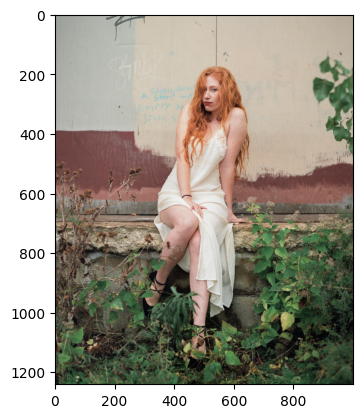

In [89]:
# Displaying the images

import matplotlib.image as mpimg

img = mpimg.imread('C:\\Users\\mypc\\Desktop\\images\\00000004.jpg')
imgplot = plt.imshow(img)
print(imgplot)

AxesImage(shape=(520, 345, 3))


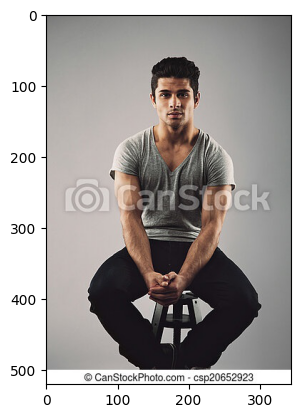

In [90]:
# Displaying some other random image

img = mpimg.imread('C:\\Users\\mypc\\Desktop\\images\\00002051.jpg')
imgplot = plt.imshow(img)
print(imgplot)

In [91]:
# Convert image names into full file paths
data["image_name"] = data["image_name"].apply(lambda x: os.path.join(image_path, x))

In [92]:
# Normalize bounding box coordinates
data["x0"] = data["x0"] / data["width"]
data["y0"] = data["y0"] / data["height"]
data["x1"] = data["x1"] / data["width"]
data["y1"] = data["y1"] / data["height"]

In [93]:
# Display dataset preview
print(data.head())

                                  image_name  width  height        x0  \
0  C:\Users\mypc\Desktop\images\00001722.jpg   1333    2000  0.367592   
1  C:\Users\mypc\Desktop\images\00001044.jpg   2000    1333  0.395500   
2  C:\Users\mypc\Desktop\images\00001050.jpg    667    1000  0.455772   
3  C:\Users\mypc\Desktop\images\00001736.jpg    626     417  0.234824   
4  C:\Users\mypc\Desktop\images\00003121.jpg    626     418  0.738019   

         y0        x1        y1  
0  0.160000  0.515379  0.332000  
1  0.089272  0.600000  0.327082  
2  0.155000  0.610195  0.331000  
3  0.033573  0.829073  0.726619  
4  0.143541  0.956869  0.397129  


In [94]:
train_df, test_df = train_test_split(data, test_size=0.2, random_state=42)

# Print dataset sizes
print(f"Training set size: {len(train_df)}")
print(f"Test set size: {len(test_df)}")


Training set size: 2680
Test set size: 670


In [95]:
# Data Augmentation Layer
data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.2),
    RandomZoom(0.2),
], name="data_augmentation")

In [96]:
# Function to preprocess images
def preprocessing(file_path, label):
    img = tf.io.read_file(file_path)
    img = tf.io.decode_jpeg(img, channels=3)  # Convert to tensor

    # Resize & normalize image
    img = tf.image.resize(img, [224, 224])  
    img = tf.cast(img, tf.float32) / 255.0  

    return img, label

In [97]:
#Convert the Pandas DataFrame into a TensorFlow Dataset.

def to_dataset(data, shuffle=True):
    data_set = tf.data.Dataset.from_tensor_slices((data["image_name"], data.drop(columns=["image_name", "width", "height"])))
    dataset = data_set.map(preprocessing)
    
    if shuffle:
        dataset = dataset.shuffle(buffer_size=1000)  # Shuffle dataset to prevent pattern memorization
    
    dataset = dataset.batch(32)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset


In [98]:
# Create training & testing datasets
train_dataset = to_dataset(train_df)
test_dataset = to_dataset(test_df, shuffle=False)

In [99]:
# Load ResNet50 without top layers
re_model = tf.keras.applications.ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=(224,224,3)
)

# Freezing base model layers
re_model.trainable = False

#Using Transfer Learning from ResNet50.

In [100]:
# Unfreeze the last few layers of ResNet50
for layer in re_model.layers[-50:]:  # Unfreezing last 50 layers
    layer.trainable = True

In [101]:
# Define Model Architecture
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)  # Correctly applying augmentation inside the model
x = re_model(x, training=False)  # Ensuring transfer learning works correctly
x = GlobalAveragePooling2D()(x)

# Fully Connected Layers with Dropout for Regularization
x = Dense(512, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = Dropout(0.5)(x)
x = Dense(256, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = Dropout(0.5)(x)

# Output Layer (Bounding Box Regression)
output = Dense(4, activation="linear")(x)

# Build Model
model = Model(inputs=inputs, outputs=output)


In [102]:
# Compile Model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='mean_squared_error',
    metrics=['mae']
)

In [103]:
lr_schedule = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,  # Reduce LR by half
    patience=2,  # Wait for 2 epochs of no improvement
    min_lr=1e-7  # Don't reduce below this value
)

In [104]:
# Define Early Stopping Callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

In [105]:
history = model.fit(train_dataset,
                     validation_data=test_dataset,
                    epochs=50, 
                    callbacks=[early_stopping])


Epoch 1/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 555s 6s/step - loss: 11.1562 - mae: 0.3032 - val_loss: 9.0802 - val_mae: 0.1781
Epoch 2/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 544s 6s/step - loss: 8.4625 - mae: 0.1944 - val_loss: 6.7082 - val_mae: 0.1794
Epoch 3/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 522s 6s/step - loss: 6.2038 - mae: 0.1764 - val_loss: 4.8277 - val_mae: 0.1480
Epoch 4/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 873s 10s/step - loss: 4.4602 - mae: 0.1692 - val_loss: 3.4277 - val_mae: 0.1334
Epoch 5/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 448s 5s/step - loss: 3.1650 - mae: 0.1614 - val_loss: 2.4193 - val_mae: 0.1393
Epoch 6/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 449s 5s/step - loss: 2.2296 - mae: 0.1567 - val_loss: 1.6946 - val_mae: 0.1298
Epoch 7/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 26116s 315s/step - loss: 1.5657 - mae: 0.1546 - val_loss: 1.1947 - val_mae: 0.1462
Epoch 8/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 5540s 67s/step - loss: 1.0993 - mae: 0.1526 - val_loss: 0.8352 - val_mae: 0.1330
Epoch 9/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 7439s 89s/step - l

In [108]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_dataset, verbose=1)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

21/21 ━━━━━━━━━━━━━━━━━━━━ 67s 3s/step - loss: 0.0270 - mae: 0.1249
Test Loss: 0.025714190676808357
Test Accuracy: 0.12202224880456924


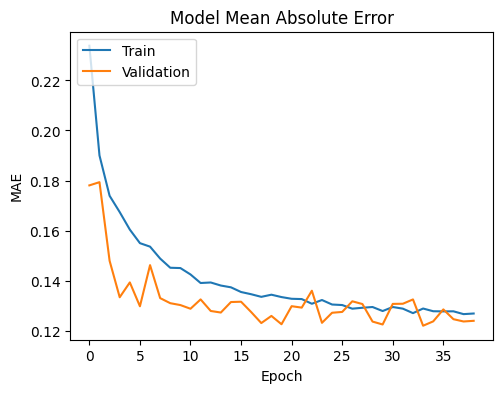

In [110]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Model Mean Absolute Error')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()


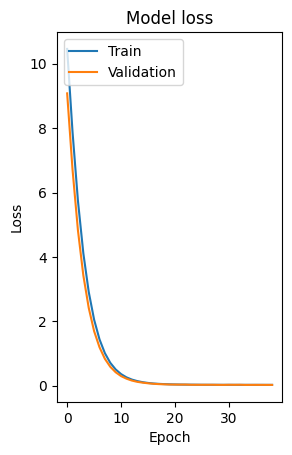

In [111]:
# Plot training & validation loss values
plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [112]:
from sklearn.metrics import precision_recall_fscore_support

# Make predictions on the test dataset
y_true = []
y_pred = []

for image, label in test_dataset.unbatch():
    y_true.append(label.numpy())
    y_pred.append(model.predict(tf.expand_dims(image, axis=0)).flatten())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

In [113]:
# Calculate Mean Squared Error (MSE)
from sklearn.metrics import mean_squared_error

y_true_flat = y_true.flatten()
y_pred_flat = y_pred.flatten()
mse = mean_squared_error(y_true_flat, y_pred_flat)
print(f"Mean Squared Error (MSE): {mse}")

Mean Squared Error (MSE): 0.024614725896262978


In [114]:
# Calculate Intersection over Union (IoU)
def calculate_iou(box1, box2):
    x1, y1, x2, y2 = box1
    x1g, y1g, x2g, y2g = box2

    xi1, yi1, xi2, yi2 = max(x1, x1g), max(y1, y1g), min(x2, x2g), min(y2, y2g)
    inter_area = max(0, xi2 - xi1) * max(0, yi2 - yi1)
    box1_area = (x2 - x1) * (y2 - y1)
    box2_area = (x2g - x1g) * (y2g - y1g)

    union_area = box1_area + box2_area - inter_area
    iou = inter_area / union_area
    return iou

ious = []
for i in range(len(y_true)):
    iou = calculate_iou(y_true[i], y_pred[i])
    ious.append(iou)

mean_iou = np.mean(ious)
print(f"Mean Intersection over Union (IoU): {mean_iou}")

Mean Intersection over Union (IoU): 0.2227612320632729


In [115]:
# Save the model in the native Keras format
model.save("my_model.keras")

In [116]:
# Load the model
from tensorflow.keras.models import load_model

loaded_model = load_model("my_model.keras")

In [117]:
def preprocessing(file_path, label, pred=False):
    img = tf.io.read_file(file_path)
    img = tf.io.decode_jpeg(img, channels=3)
    height_img = img.shape[0]
    width_img = img.shape[1]
    img = tf.image.resize(img, [224, 224])
    img = tf.cast(img, tf.float32) / 255.0
    if pred:
        return img, width_img, height_img
    return img, label

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


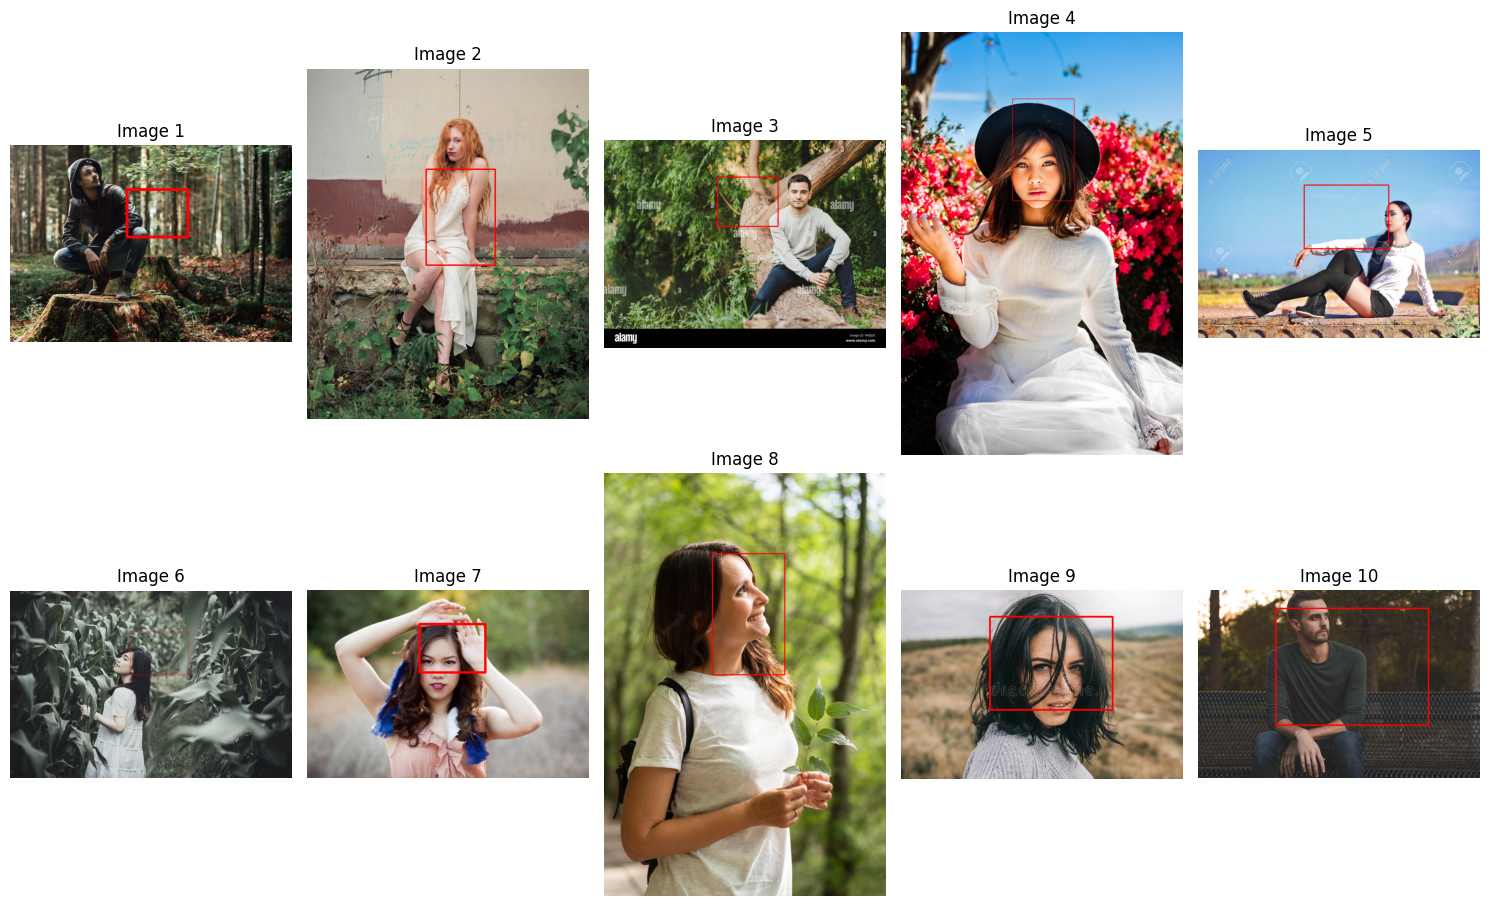

In [129]:
def predict_and_visualize_multiple(img_paths):
    plt.figure(figsize=(15, 10))

    for i, img_path in enumerate(img_paths):
        # Preprocess image
        test_img, width, height = preprocessing(img_path, None, pred=True)
        test_img = tf.reshape(test_img, (1, 224, 224, 3))

        # Make prediction
        pred = model.predict(test_img)

        # Read the image
        imr = cv2.imread(img_path)
        imr = cv2.cvtColor(imr, cv2.COLOR_BGR2RGB)  # Convert to RGB

        # Scale predictions back to original image dimensions
        x0 = int(pred[0][0] * width)
        y0 = int(pred[0][1] * height)
        x1 = int(pred[0][2] * width)
        y1 = int(pred[0][3] * height)

        # Draw rectangle on image
        p1 = (x0, y0)
        p2 = (x1, y1)
        color = (255, 0, 0)
        thickness = 3
        cv2.rectangle(imr, p1, p2, color, thickness)

        # Display the image in a grid
        plt.subplot(2, 5, i + 1)  # Adjust grid size based on the number of images
        plt.imshow(imr)
        plt.axis('off')
        plt.title(f'Image {i + 1}')

    plt.tight_layout()
    plt.show()

# Example usage with the first 10 images
image_folder = 'C:\\Users\\mypc\\Desktop\\images'
image_files = os.listdir(image_folder)
image_paths = [os.path.join(image_folder, img_file) for img_file in image_files[:10]]  # Adjust range as needed

predict_and_visualize_multiple(image_paths)